<a href="https://colab.research.google.com/github/JaysaKeylla/minisom/blob/main/minisom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install minisom tqdm

  Created wheel for minisom: filename=MiniSom-2.2.9-cp37-none-any.whl size=8603 sha256=e2dfbfd5fd89216295fe50f53433af37e489863c2e43664f9a1181f93f7102ef
  Stored in directory: /root/.cache/pip/wheels/de/a0/08/5234d6b02b29c561f62b6c985e2eb7d480fb0b92359a8c74e4
Successfully built minisom


In [12]:
from collections import Counter
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, Draw
from rdkit import DataStructs
import numpy as np
from tqdm import tqdm
from minisom import MiniSom
import sys
from time import time
import math
%matplotlib inline

In [13]:
def maccs_as_np(mol):
    """
    Generate MACCS fingerprints as a NumPy array
    :param mol: input molecule
    :return: fingerprint as a NumPy array
    """
    bv = MACCSkeys.GenMACCSKeys(mol)
    return np.array([int(x) for x in list(bv.ToBitString())], dtype=np.float32)


def morgan_as_np(mol):
    """
    Generate a 1024 bit Morgan fingerprint as a NumPy array
    :param mol: input molecule
    :return: fingerprint as a NumPy array
    """
    bv = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024)
    arr = np.zeros((1,), dtype=np.float32)
    DataStructs.ConvertToNumpyArray(bv, arr)
    return arr


def generate_fps(smiles_list, fp_function=maccs_as_np):
    """
    Take a list of SMILES as input and return a list of NumPy arrays
    :param smiles_list: list of SMILES
    :param fp_function: function to calculate fingerprints
    :return: list of NumPy arrays containing fingerprints
    """
    output_fp_list = []
    for smiles in tqdm(smiles_list, desc="Generating Fingerprints"):
        output_fp_list.append(fp_function(Chem.MolFromSmiles(smiles)))
    return output_fp_list





In [15]:
def depict_som(cluster_df, x_dim, y_dim, x_column="X", y_column="Y"):
    """
    Draw a SOM with each cell depicted as a pie chart
    :param cluster_df: data frame with SOM output, should have columns active, X, and Y
    :param x_dim: X dimension of the SOM
    :param y_dim: Y dimension of the SOM
    :return:
    """
    required_colums = [x_column, y_column, "active"]
    for col in required_colums:
        if col not in cluster_df.columns:
            print(f"Error {col} not in dataframe columns", file=sys.stderr)
            sys.exit(1)
    cell_dict = {}
    for k, v in [x for x in cluster_df.groupby([x_column, y_column])]:
        cell_dict[k] = Counter(v["active"])
        cell_names = cluster_df["active"].unique()
    plt.figure(figsize=(x_dim, y_dim))
    the_grid = GridSpec(x_dim, y_dim)
    for position in cell_dict.keys():
        label_fracs = [cell_dict[position][l] for l in cell_names]
        plt.subplot(the_grid[(x_dim - 1) - position[1], position[0]], aspect=1)
        patches, texts = plt.pie(label_fracs)

In [16]:
def build_minisom_som(fp_list_in, x_dim=10, y_dim=10, num_iters=20000):
    """
    Build a SOM with MiniSom
    :param fp_list_in: input list of fingerprints as NumPy arrays
    :param x_dim: X dimension of the SOM
    :param y_dim: Y dimension of the SOM
    :param num_iters: number of iterations when building the SOM
    :return: lists with X and Y coordinates in the SOM
    """
    print("Training SOM")
    start_time = time()
    som = MiniSom(x_dim, y_dim, len(fp_list_in[0]), sigma=0.3, learning_rate=0.5, random_seed=1)
    som.train_random(fp_list_in, num_iters)
    x = []
    y = []
    # find best matching units
    print("Finding BMUs")
    for row in fp_list_in:
        x_val, y_val = som.winner(row)
        x.append(x_val)
        y.append(y_val)
    elapsed_time = time()-start_time
    print("Done\nElapsed time = %.2f sec" % elapsed_time)
    return x, y

Generating Fingerprints: 100%|██████████| 4629/4629 [00:06<00:00, 683.98it/s]


Training SOM
Finding BMUs
Done
Elapsed time = 2.89 sec


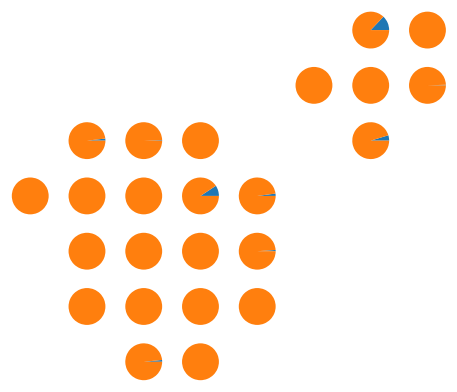

In [18]:
# read the input file into a dataframe
act_df = pd.read_csv('https://raw.githubusercontent.com/JaysaKeylla/minisom/main/dude_erk2_mk01.csv')
# generate fingerprints
fp_list = generate_fps(act_df.SMILES)
# build the SOM
x_dim = 10
y_dim = 10
som_x, som_y = build_minisom_som(fp_list, x_dim, y_dim)
# set dataframe columns to SOM output
act_df["X"] = som_x
act_df["Y"] = som_y
# Draw the SOM
depict_som(act_df, x_dim, y_dim)

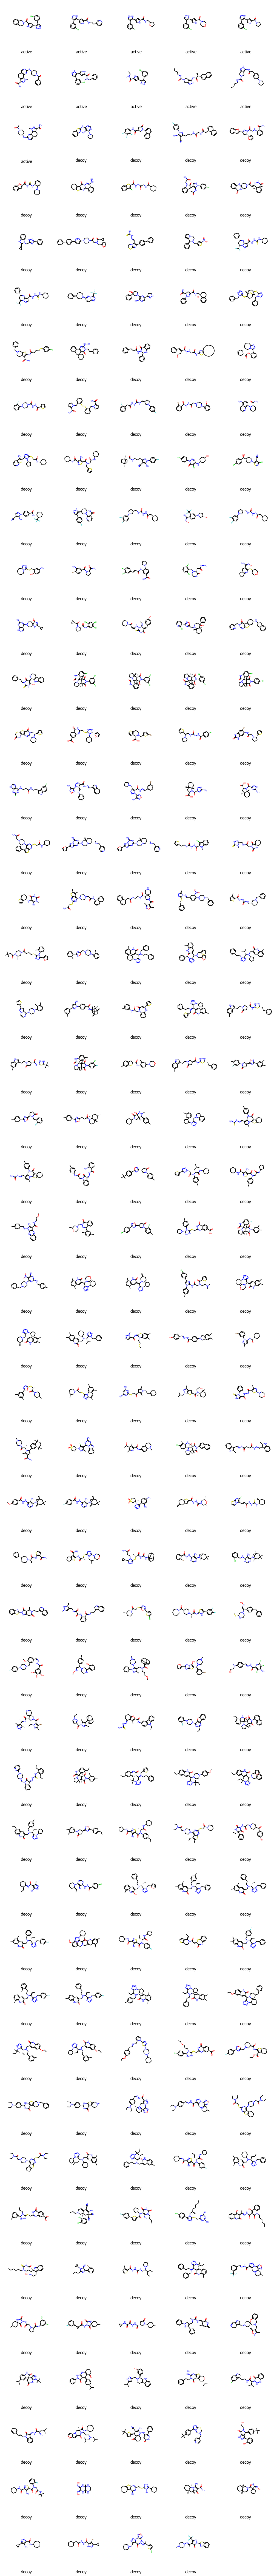

In [21]:
my_cell = act_df.query("X==6 and Y==4")
my_smiles_list = [x[1] for x in sorted(zip(my_cell.active,my_cell.SMILES),reverse=True)]
my_active_list = [x[0] for x in sorted(zip(my_cell.active,my_cell.SMILES),reverse=True)]
active_label_list = ["active" if a else "decoy" for a in my_active_list]
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in my_smiles_list],molsPerRow=5,legends=active_label_list)

Generating Fingerprints: 100%|██████████| 4629/4629 [00:01<00:00, 3256.95it/s]


Training SOM
Finding BMUs
Done
Elapsed time = 25.84 sec


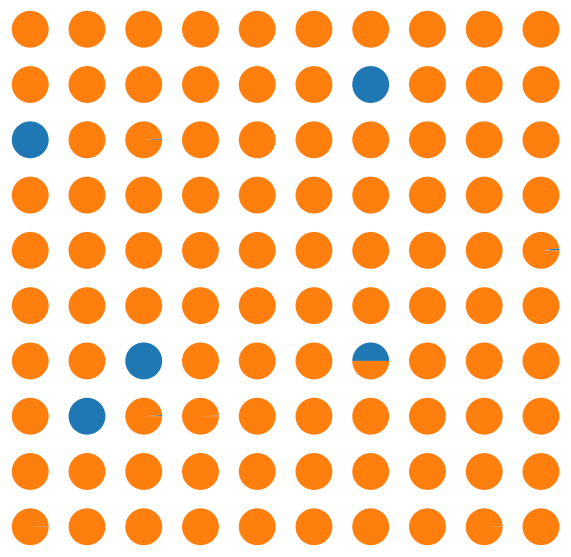

In [22]:
morgan_list = generate_fps(act_df.SMILES,morgan_as_np)
x_dim = 10
y_dim = 10
morgan_x, morgan_y = build_minisom_som(morgan_list, x_dim, y_dim)
act_df["morgan_X"] = morgan_x
act_df["morgan_Y"] = morgan_y
depict_som(act_df, x_dim, y_dim, x_column="morgan_X",y_column="morgan_Y")